This notebook contains functionality to perform the following:

Read in the sequences_activity_*set*.txt and sequences_*set*.fa drosophila files, drop bad rows, format, and save dataset as drosophila_truncated.csv. Read in output.csv (Drosophila target value) and visualize/examine summary statistics. Do some real hacky nonsense to try to figure out the NaN bug I was having by combining the drosophila and arabidopsis datasets, please ignore the last bit.

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/Shareddrives/NRC_Amii_Agronomics_Project/nrc-ml-plant-genomics/'

Mounted at /content/drive
/content/drive/Shareddrives/NRC_Amii_Agronomics_Project/nrc-ml-plant-genomics


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
import time

%matplotlib inline

In [ ]:
pwd

'/content/drive/Shareddrives/NRC_Amii_Agronomics_Project/nrc-ml-plant-genomics'

Load Data

In [ ]:
activity_train_df = pd.read_csv('data/raw/drosophila/Sequences_activity_Train.txt', sep="\t")[["Dev_log2_enrichment_quantile_normalized", "Hk_log2_enrichment_quantile_normalized"]]
activity_test_df = pd.read_csv('data/raw/drosophila/Sequences_activity_Test.txt', sep="\t")[["Dev_log2_enrichment_quantile_normalized", "Hk_log2_enrichment_quantile_normalized"]]
activity_val_df = pd.read_csv('data/raw/drosophila/Sequences_activity_Val.txt', sep="\t")[["Dev_log2_enrichment_quantile_normalized", "Hk_log2_enrichment_quantile_normalized"]]

activity_train_df["set"] = "train"
activity_test_df["set"] = "test"
activity_val_df["set"] = "val"

In [ ]:
print(activity_train_df.Dev_log2_enrichment_quantile_normalized.max())
print(activity_train_df.Dev_log2_enrichment_quantile_normalized.min())

8.45433053282941
-4.89272508967323


In [ ]:
activity_train_df.shape

(402296, 3)

In [ ]:
# # TARGET VALUE HOSPITAL

# def normd_series(df, column):
#   return (df[column]-df[column].mean())/df[column].std()

# # try normalizing values
# activity_train_df.loc[:,"Dev_log2_enrichment_quantile_normalized"] = normd_series(activity_train_df, "Dev_log2_enrichment_quantile_normalized")
# activity_train_df.loc[:,"Hk_log2_enrichment_quantile_normalized"] = normd_series(activity_train_df, "Hk_log2_enrichment_quantile_normalized")

In [ ]:
activity_train_df.head()

,Dev_log2_enrichment_quantile_normalized,Hk_log2_enrichment_quantile_normalized,set
0,6.046261,1.711032,train
1,5.604215,1.974276,train
2,2.312282,0.606119,train
3,1.254361,3.780414,train
4,2.658029,0.714676,train


In [ ]:
((activity_train_df.Dev_log2_enrichment_quantile_normalized > 0.01) | (activity_train_df.Dev_log2_enrichment_quantile_normalized < -0.01))

0         True
1         True
2         True
3         True
4         True
          ... 
402291    True
402292    True
402293    True
402294    True
402295    True
Name: Dev_log2_enrichment_quantile_normalized, Length: 402296, dtype: bool

In [ ]:
sum(((activity_train_df.Dev_log2_enrichment_quantile_normalized > 0.01) | (activity_train_df.Dev_log2_enrichment_quantile_normalized < -0.01)))

399702

In [ ]:
f = open('data/raw/drosophila/Sequences_Train.fa')
s = f.read().split("\n")
sequence_train_list = [s[i] for i in range(len(s)) if i%2==1]
f.close()

f = open('data/raw/drosophila/Sequences_Test.fa')
s = f.read().split("\n")
sequence_test_list = [s[i] for i in range(len(s)) if i%2==1]
f.close()

f = open('data/raw/drosophila/Sequences_Val.fa')
s = f.read().split("\n")
sequence_val_list = [s[i] for i in range(len(s)) if i%2==1]
f.close()

In [ ]:
len(sequence_train_list)

402296

In [ ]:
activity_train_df["sequence"] = sequence_train_list
activity_test_df["sequence"] = sequence_test_list
activity_val_df["sequence"] = sequence_val_list

In [ ]:
df = pd.concat([activity_train_df, activity_test_df, activity_val_df])

In [ ]:
df = df.rename(columns={"Dev_log2_enrichment_quantile_normalized":"dev_target", "Hk_log2_enrichment_quantile_normalized":"hk_target"})

In [ ]:
df

,dev_target,hk_target,set,sequence
0,6.046261,1.711032,train,ATTCAGATTGCCTCTCATTGTCTCACCCATATTATGGGAACCAAAT...
1,5.604215,1.974276,train,AAATGGCCGCTCAAGAAAAGGCTCGAATATATATTGCCTGCCTCTC...
2,2.312282,0.606119,train,ATAAGGATCAAAAAGTCCTGATTTCCGAAATGGCGGTTCTCCTTCA...
3,1.254361,3.780414,train,TTTCCATGACTGACTGGAATGGGTGGAGAACATCGCTTTGGGAGTG...
4,2.658029,0.714676,train,TCTATCGACCCATAGCCGTAGTCGCTAGACCCGCCCTTCGGAGCAT...
...,...,...,...,...
40565,1.238013,-0.517860,val,GCAAATCATGAAGGTGGAATATATATATAGCAGATCTAAACCCTTC...
40566,0.052251,-1.155432,val,AAGTATTTTCCCAATTTCCCATACCGCACCCAGCTGCATTTCCCAT...
40567,0.235486,-0.150081,val,TTAATTTAAAGTACTTCCCATCAGCTTTTTGTGCATTTTTCCCATG...
40568,-0.456804,0.882345,val,GTCGTCTTACACTCGCAGCAAAACTTGTAAATTAAAAATGCGTCCA...


In [ ]:
(df.sequence.str.len() == 249).all()

True

In [ ]:
# # uncomment if you want to truncate
# df.loc[:,"sequence"] = df.loc[:,"sequence"].str[:145]
# (df.sequence.str.len() == 145).all()

In [ ]:
df

,dev_target,hk_target,set,sequence
0,6.046261,1.711032,train,ATTCAGATTGCCTCTCATTGTCTCACCCATATTATGGGAACCAAAT...
1,5.604215,1.974276,train,AAATGGCCGCTCAAGAAAAGGCTCGAATATATATTGCCTGCCTCTC...
2,2.312282,0.606119,train,ATAAGGATCAAAAAGTCCTGATTTCCGAAATGGCGGTTCTCCTTCA...
3,1.254361,3.780414,train,TTTCCATGACTGACTGGAATGGGTGGAGAACATCGCTTTGGGAGTG...
4,2.658029,0.714676,train,TCTATCGACCCATAGCCGTAGTCGCTAGACCCGCCCTTCGGAGCAT...
...,...,...,...,...
40565,1.238013,-0.517860,val,GCAAATCATGAAGGTGGAATATATATATAGCAGATCTAAACCCTTC...
40566,0.052251,-1.155432,val,AAGTATTTTCCCAATTTCCCATACCGCACCCAGCTGCATTTCCCAT...
40567,0.235486,-0.150081,val,TTAATTTAAAGTACTTCCCATCAGCTTTTTGTGCATTTTTCCCATG...
40568,-0.456804,0.882345,val,GTCGTCTTACACTCGCAGCAAAACTTGTAAATTAAAAATGCGTCCA...


In [ ]:
# now check for weird characters
genome = "".join(df.sequence.tolist())

In [ ]:
Counter(genome)

Counter({'A': 35461277, 'C': 24802784, 'G': 24802784, 'N': 826, 'T': 35461277})

In [ ]:
genome[:20]

'ATTCAGATTGCCTCTCATTG'

In [ ]:
mask = [True if "N" in s else False for s in df.sequence]

In [ ]:
len(df.sequence.tolist())

484052

In [ ]:
len(mask)

484052

In [ ]:
df = df.iloc[np.logical_not(mask),:]

In [ ]:
# new test
genome = "".join(df.sequence.tolist())
Counter(genome)

# passed

Counter({'A': 35460106, 'C': 24802127, 'G': 24802127, 'T': 35460106})

In [ ]:
# # uncomment if you want small
# df = df.iloc[::16, :]

In [ ]:
df.loc[((df.dev_target > 0.01) | (df.dev_target < -0.01)),:]

,dev_target,hk_target,set,sequence
0,6.046261,1.711032,train,ATTCAGATTGCCTCTCATTGTCTCACCCATATTATGGGAACCAAAT...
1,5.604215,1.974276,train,AAATGGCCGCTCAAGAAAAGGCTCGAATATATATTGCCTGCCTCTC...
2,2.312282,0.606119,train,ATAAGGATCAAAAAGTCCTGATTTCCGAAATGGCGGTTCTCCTTCA...
3,1.254361,3.780414,train,TTTCCATGACTGACTGGAATGGGTGGAGAACATCGCTTTGGGAGTG...
4,2.658029,0.714676,train,TCTATCGACCCATAGCCGTAGTCGCTAGACCCGCCCTTCGGAGCAT...
...,...,...,...,...
40565,1.238013,-0.517860,val,GCAAATCATGAAGGTGGAATATATATATAGCAGATCTAAACCCTTC...
40566,0.052251,-1.155432,val,AAGTATTTTCCCAATTTCCCATACCGCACCCAGCTGCATTTCCCAT...
40567,0.235486,-0.150081,val,TTAATTTAAAGTACTTCCCATCAGCTTTTTGTGCATTTTTCCCATG...
40568,-0.456804,0.882345,val,GTCGTCTTACACTCGCAGCAAAACTTGTAAATTAAAAATGCGTCCA...


In [ ]:
out_file_name = "data/processed/drosophila_truncated.csv"

df.to_csv(out_file_name, index=False)  # write to file

---
## Test Target Distribution

In [ ]:
ls

 data/         'Larry Proposal.gdoc'   notebooks/   requirements.txt
 driver.ipynb   legacy/                output.csv   src/
 experiments/   models/                README.md


In [ ]:
df = pd.read_csv("output.csv", header=None)

In [ ]:
df[0].min()

-4.89272508967323

In [ ]:
df[0].max()

8.45433053282941

In [ ]:
df[0].mean()

0.14325634461029768

In [ ]:
df[0].std()

1.5794728257432586

In [ ]:
df[0].isnull().any()

False

In [ ]:
df[0].eq(0).any()

False

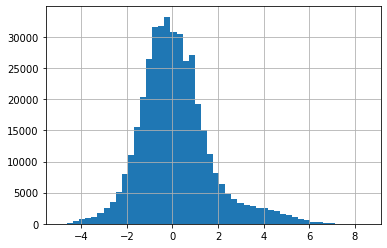

In [ ]:
df[0].hist(bins=50)
plt.show()

---
## Test Russ' idea of combining Arabidopsis and Drosophila?

Run this code up until the point the df is saved and truncate sequences to 145

In [ ]:
df.head()

,dev_target,hk_target,set,sequence
0,6.046261,1.711032,train,ATTCAGATTGCCTCTCATTGTCTCACCCATATTATGGGAACCAAAT...
1,5.604215,1.974276,train,AAATGGCCGCTCAAGAAAAGGCTCGAATATATATTGCCTGCCTCTC...
2,2.312282,0.606119,train,ATAAGGATCAAAAAGTCCTGATTTCCGAAATGGCGGTTCTCCTTCA...
3,1.254361,3.780414,train,TTTCCATGACTGACTGGAATGGGTGGAGAACATCGCTTTGGGAGTG...
4,2.658029,0.714676,train,TCTATCGACCCATAGCCGTAGTCGCTAGACCCGCCCTTCGGAGCAT...


In [ ]:
ls

 data/         'Larry Proposal.gdoc'   notebooks/   requirements.txt
 driver.ipynb   legacy/                output.csv   src/
 experiments/   models/                README.md


In [ ]:
# load in arabidopsis dataset
df_a = pd.read_csv("data/processed/arabidopsis_every_16.csv")

In [ ]:
df_a

,chromosome,start_coord,end_coord,sequence,target_starr,target_istarr,set
0,Chr1,3520,3665,TAAAACCATACCAATTAAACCGGAGATCCATATTAATTTAATTAAG...,-0.439532,0.604071,train
1,Chr1,3600,3745,AAACGCTGACTTCACTGTCTTCCTCCCTCCAAATTATTAGATATAC...,-0.439532,0.317482,train
2,Chr1,3680,3825,TACAGATTACAGAGAGCGAGAGAGATCGACGGCGAAGCTCTTTACC...,-0.140178,0.171611,train
3,Chr1,3920,4065,CCGAATTTTCTGAATTTCATTTGCAAGTAATCGATTTAGGTTTTTG...,-0.055142,0.153805,train
4,Chr1,4000,4145,TCAAAGTACAAATCGAGAGATGCTATGTGGTACTTCTTCTCTCGTA...,-0.356694,0.121015,train
...,...,...,...,...,...,...,...
994516,Chr5,26975000,26975145,AAATAAGGTAGAGTGACAATTCTTTCTAATGTTCATTTGAAATAAA...,0.800391,1.026800,train
994517,Chr5,26975080,26975225,AAAATAAAAATAAAATAAAGTAGAGTGAACCTAACATTTTGGAAGA...,0.476438,0.252981,train
994518,Chr5,26975160,26975305,CCGACCCGACCACTTAACCACAAAACAATTTCAAAATTATGAAGCA...,0.533979,0.272620,train
994519,Chr5,26975240,26975385,ATGGGCTTGACCCGCTTGTGCTCACGGCCGGCTCTGGTCTAAACAC...,0.496676,-0.091630,train


In [ ]:
# df_a = df_a.rename(columns={"target_starr":"dev_target", "target_istarr":"hk_target"})

In [ ]:
df["chromosome"] = "None"
df["start_coord"] = 0
df["end_coord"] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df

,dev_target,hk_target,set,sequence,chromosome,start_coord,end_coord
0,6.046261,1.711032,train,ATTCAGATTGCCTCTCATTGTCTCACCCATATTATGGGAACCAAAT...,None,0,0
1,5.604215,1.974276,train,AAATGGCCGCTCAAGAAAAGGCTCGAATATATATTGCCTGCCTCTC...,None,0,0
2,2.312282,0.606119,train,ATAAGGATCAAAAAGTCCTGATTTCCGAAATGGCGGTTCTCCTTCA...,None,0,0
3,1.254361,3.780414,train,TTTCCATGACTGACTGGAATGGGTGGAGAACATCGCTTTGGGAGTG...,None,0,0
4,2.658029,0.714676,train,TCTATCGACCCATAGCCGTAGTCGCTAGACCCGCCCTTCGGAGCAT...,None,0,0
...,...,...,...,...,...,...,...
40565,1.238013,-0.517860,val,GCAAATCATGAAGGTGGAATATATATATAGCAGATCTAAACCCTTC...,None,0,0
40566,0.052251,-1.155432,val,AAGTATTTTCCCAATTTCCCATACCGCACCCAGCTGCATTTCCCAT...,None,0,0
40567,0.235486,-0.150081,val,TTAATTTAAAGTACTTCCCATCAGCTTTTTGTGCATTTTTCCCATG...,None,0,0
40568,-0.456804,0.882345,val,GTCGTCTTACACTCGCAGCAAAACTTGTAAATTAAAAATGCGTCCA...,None,0,0


In [ ]:
df = df.rename(columns={"dev_target":"target_starr", "hk_target":"target_istarr"})
df = df[["chromosome", "start_coord", "end_coord", "sequence", "target_starr", "target_istarr", "set"]]

# df = df[["chromosome", "start_coord", "end_coord", "sequence", "dev_target", "hk_target", "set"]]

In [ ]:
df_final = pd.concat([df, df_a])

In [ ]:
df_final = df_final[df_final.chromosome=="None"]

In [ ]:
df_final

,chromosome,start_coord,end_coord,sequence,target_starr,target_istarr,set
0,None,0,0,ATTCAGATTGCCTCTCATTGTCTCACCCATATTATGGGAACCAAAT...,6.046261,1.711032,train
1,None,0,0,AAATGGCCGCTCAAGAAAAGGCTCGAATATATATTGCCTGCCTCTC...,5.604215,1.974276,train
2,None,0,0,ATAAGGATCAAAAAGTCCTGATTTCCGAAATGGCGGTTCTCCTTCA...,2.312282,0.606119,train
3,None,0,0,TTTCCATGACTGACTGGAATGGGTGGAGAACATCGCTTTGGGAGTG...,1.254361,3.780414,train
4,None,0,0,TCTATCGACCCATAGCCGTAGTCGCTAGACCCGCCCTTCGGAGCAT...,2.658029,0.714676,train
...,...,...,...,...,...,...,...
40565,None,0,0,GCAAATCATGAAGGTGGAATATATATATAGCAGATCTAAACCCTTC...,1.238013,-0.517860,val
40566,None,0,0,AAGTATTTTCCCAATTTCCCATACCGCACCCAGCTGCATTTCCCAT...,0.052251,-1.155432,val
40567,None,0,0,TTAATTTAAAGTACTTCCCATCAGCTTTTTGTGCATTTTTCCCATG...,0.235486,-0.150081,val
40568,None,0,0,GTCGTCTTACACTCGCAGCAAAACTTGTAAATTAAAAATGCGTCCA...,-0.456804,0.882345,val


In [ ]:
df_final.sequence.str.len().mean()

249.0

In [ ]:
df_final.to_csv("data/processed/drosophila_arabidopsis.csv", index=False)  # write to file